In [1]:
import warnings
warnings.filterwarnings('ignore')

import timeit
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
path = Path('data', 'weatherAUS_clean.csv')
df = pd.read_csv(path)

In [3]:
# split into train and test
y = df.pop('RainTomorrow_Yes')
train_X, test_X, train_y, test_y = train_test_split(df, y, test_size= 0.2, random_state=42)

In [4]:
# Logistic Regression --------------------------------------------------------
parameter_space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', '11', '12', 'elasticnet'],
    'C': [0.001, 1, 1000],
}
log_reg = LogisticRegression()
log_reg = GridSearchCV(log_reg, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
log_reg.fit(train_X, train_y)
stop = timeit.default_timer()
print('Logistic Regression Runtime: %0.0f seconds' % (stop - start))

# Decision Tree --------------------------------------------------------------
parameter_space = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': ['None', 5, 10, 20],
    'min_samples_split': [2, 3, 4],
    'max_leaf_nodes': ['None', 30, 50, 100],
}
dec_tree = DecisionTreeClassifier()
dec_tree = GridSearchCV(dec_tree, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
dec_tree.fit(train_X, train_y)
stop = timeit.default_timer()
print('Decision Tree Runtime: %0.0f seconds' % (stop - start))

# Bagged Tree ---------------------------------------------------------------
parameter_space = {
    'n_estimators' : [10, 50, 100, 200],
    'max_features' : [1, 0.5, 1.0, 10.0, 10],
}
bag_tree = BaggingClassifier()
bag_tree = GridSearchCV(bag_tree, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
bag_tree.fit(train_X, train_y)
stop = timeit.default_timer()
print('Bagged Tree Runtime: %0.0f seconds' % (stop - start))

# Random Forest -------------------------------------------------------------
parameter_space = {
    'n_estimators' : [10, 50, 100, 200],
    'max_features' : ['sqrt', 'log2', None],
}
ran_forest = RandomForestClassifier()
ran_forest = GridSearchCV(ran_forest, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
ran_forest.fit(train_X, train_y)
stop = timeit.default_timer()
print('Random Forest Runtime: %0.0f seconds' % (stop - start))

Logistic Regression Runtime: 136 seconds
Decision Tree Runtime: 76 seconds
Bagged Tree Runtime: 641 seconds
Random Forest Runtime: 354 seconds


## Evaluation metrics

In [5]:
# Logistic Regression
print('\n---------- Logistic Regression Metrics: ------------')
print('Best parameters found: ', log_reg.best_params_)
print('Mean-CV accuracy on training data: %0.3f' % log_reg.best_score_)
pred_logReg = log_reg.predict(test_X)
print(metrics.classification_report(test_y, pred_logReg, digits=3))

# Decision Tree
print('\n---------- Decision Tree Metrics: ------------')
print('Best parameters found: ', dec_tree.best_params_)
print('Mean-CV accuracy on training data: %0.3f' % dec_tree.best_score_)
pred_decTree = dec_tree.predict(test_X)
print(metrics.classification_report(test_y, pred_decTree, digits=3))

# Bagged Tree
print('\n---------- Bagged Tree Metrics: ------------')
print('Best parameters found: ', bag_tree.best_params_)
print('Mean-CV accuracy on training data: %0.3f' % bag_tree.best_score_)
pred_bagTree = bag_tree.predict(test_X)
print(metrics.classification_report(test_y, pred_bagTree, digits=3))

# Random Forest
print('\n---------- Random Forest Metrics: ------------')
print('Best parameters found on training data: ', ran_forest.best_params_)
print('Mean-CV accuracy: %0.3f' % ran_forest.best_score_)
pred_ranForest = ran_forest.predict(test_X)
print(metrics.classification_report(test_y, pred_ranForest, digits=3))


---------- Logistic Regression Metrics: ------------
Best parameters found:  {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
Mean-CV accuracy on training data: 0.851
              precision    recall  f1-score   support

           0      0.879     0.943     0.910     19229
           1      0.730     0.541     0.622      5445

    accuracy                          0.855     24674
   macro avg      0.804     0.742     0.766     24674
weighted avg      0.846     0.855     0.846     24674


---------- Decision Tree Metrics: ------------
Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'splitter': 'best'}
Mean-CV accuracy on training data: 0.841
              precision    recall  f1-score   support

           0      0.870     0.945     0.906     19229
           1      0.722     0.501     0.592      5445

    accuracy                          0.847     24674
   macro avg      0.796     0.723     0.749     24674
weighted

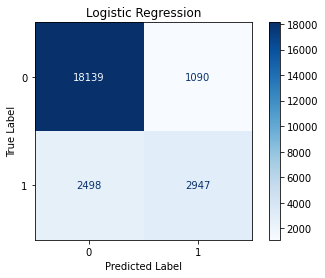

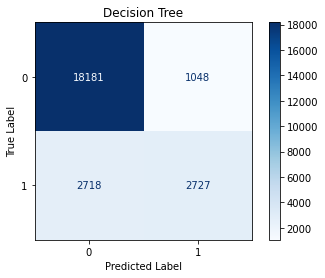

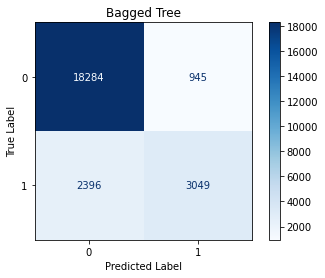

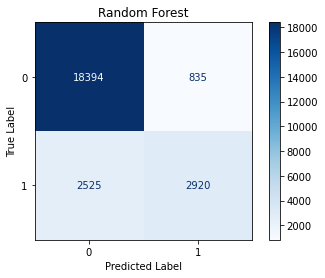

In [6]:
# Confusion Matrix
models = [log_reg, dec_tree, bag_tree, ran_forest]
names = ['Logistic Regression', 'Decision Tree', 'Bagged Tree', 'Random Forest']
color = 'black'
for model, name in zip(models, names):
    cm_plot = metrics.plot_confusion_matrix(model, test_X, test_y, cmap=plt.cm.Blues)
    cm_plot.ax_.set_title(name, color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()

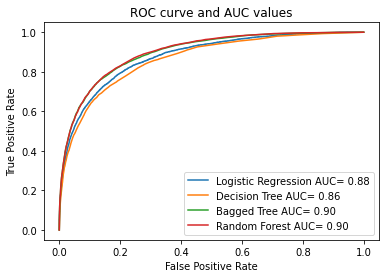

In [7]:
# ROC curves and AUC values
for model, name in zip(models, names):
    y_pred_proba = model.predict_proba(test_X)[::,1]
    fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
    auc = roc_auc_score(test_y, y_pred_proba)

    # create ROC curve
    label = "AUC= %0.2f" % auc
    plt.plot(fpr, tpr, label = name+' '+label)
    plt.title('ROC curve and AUC values')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

plt.show()

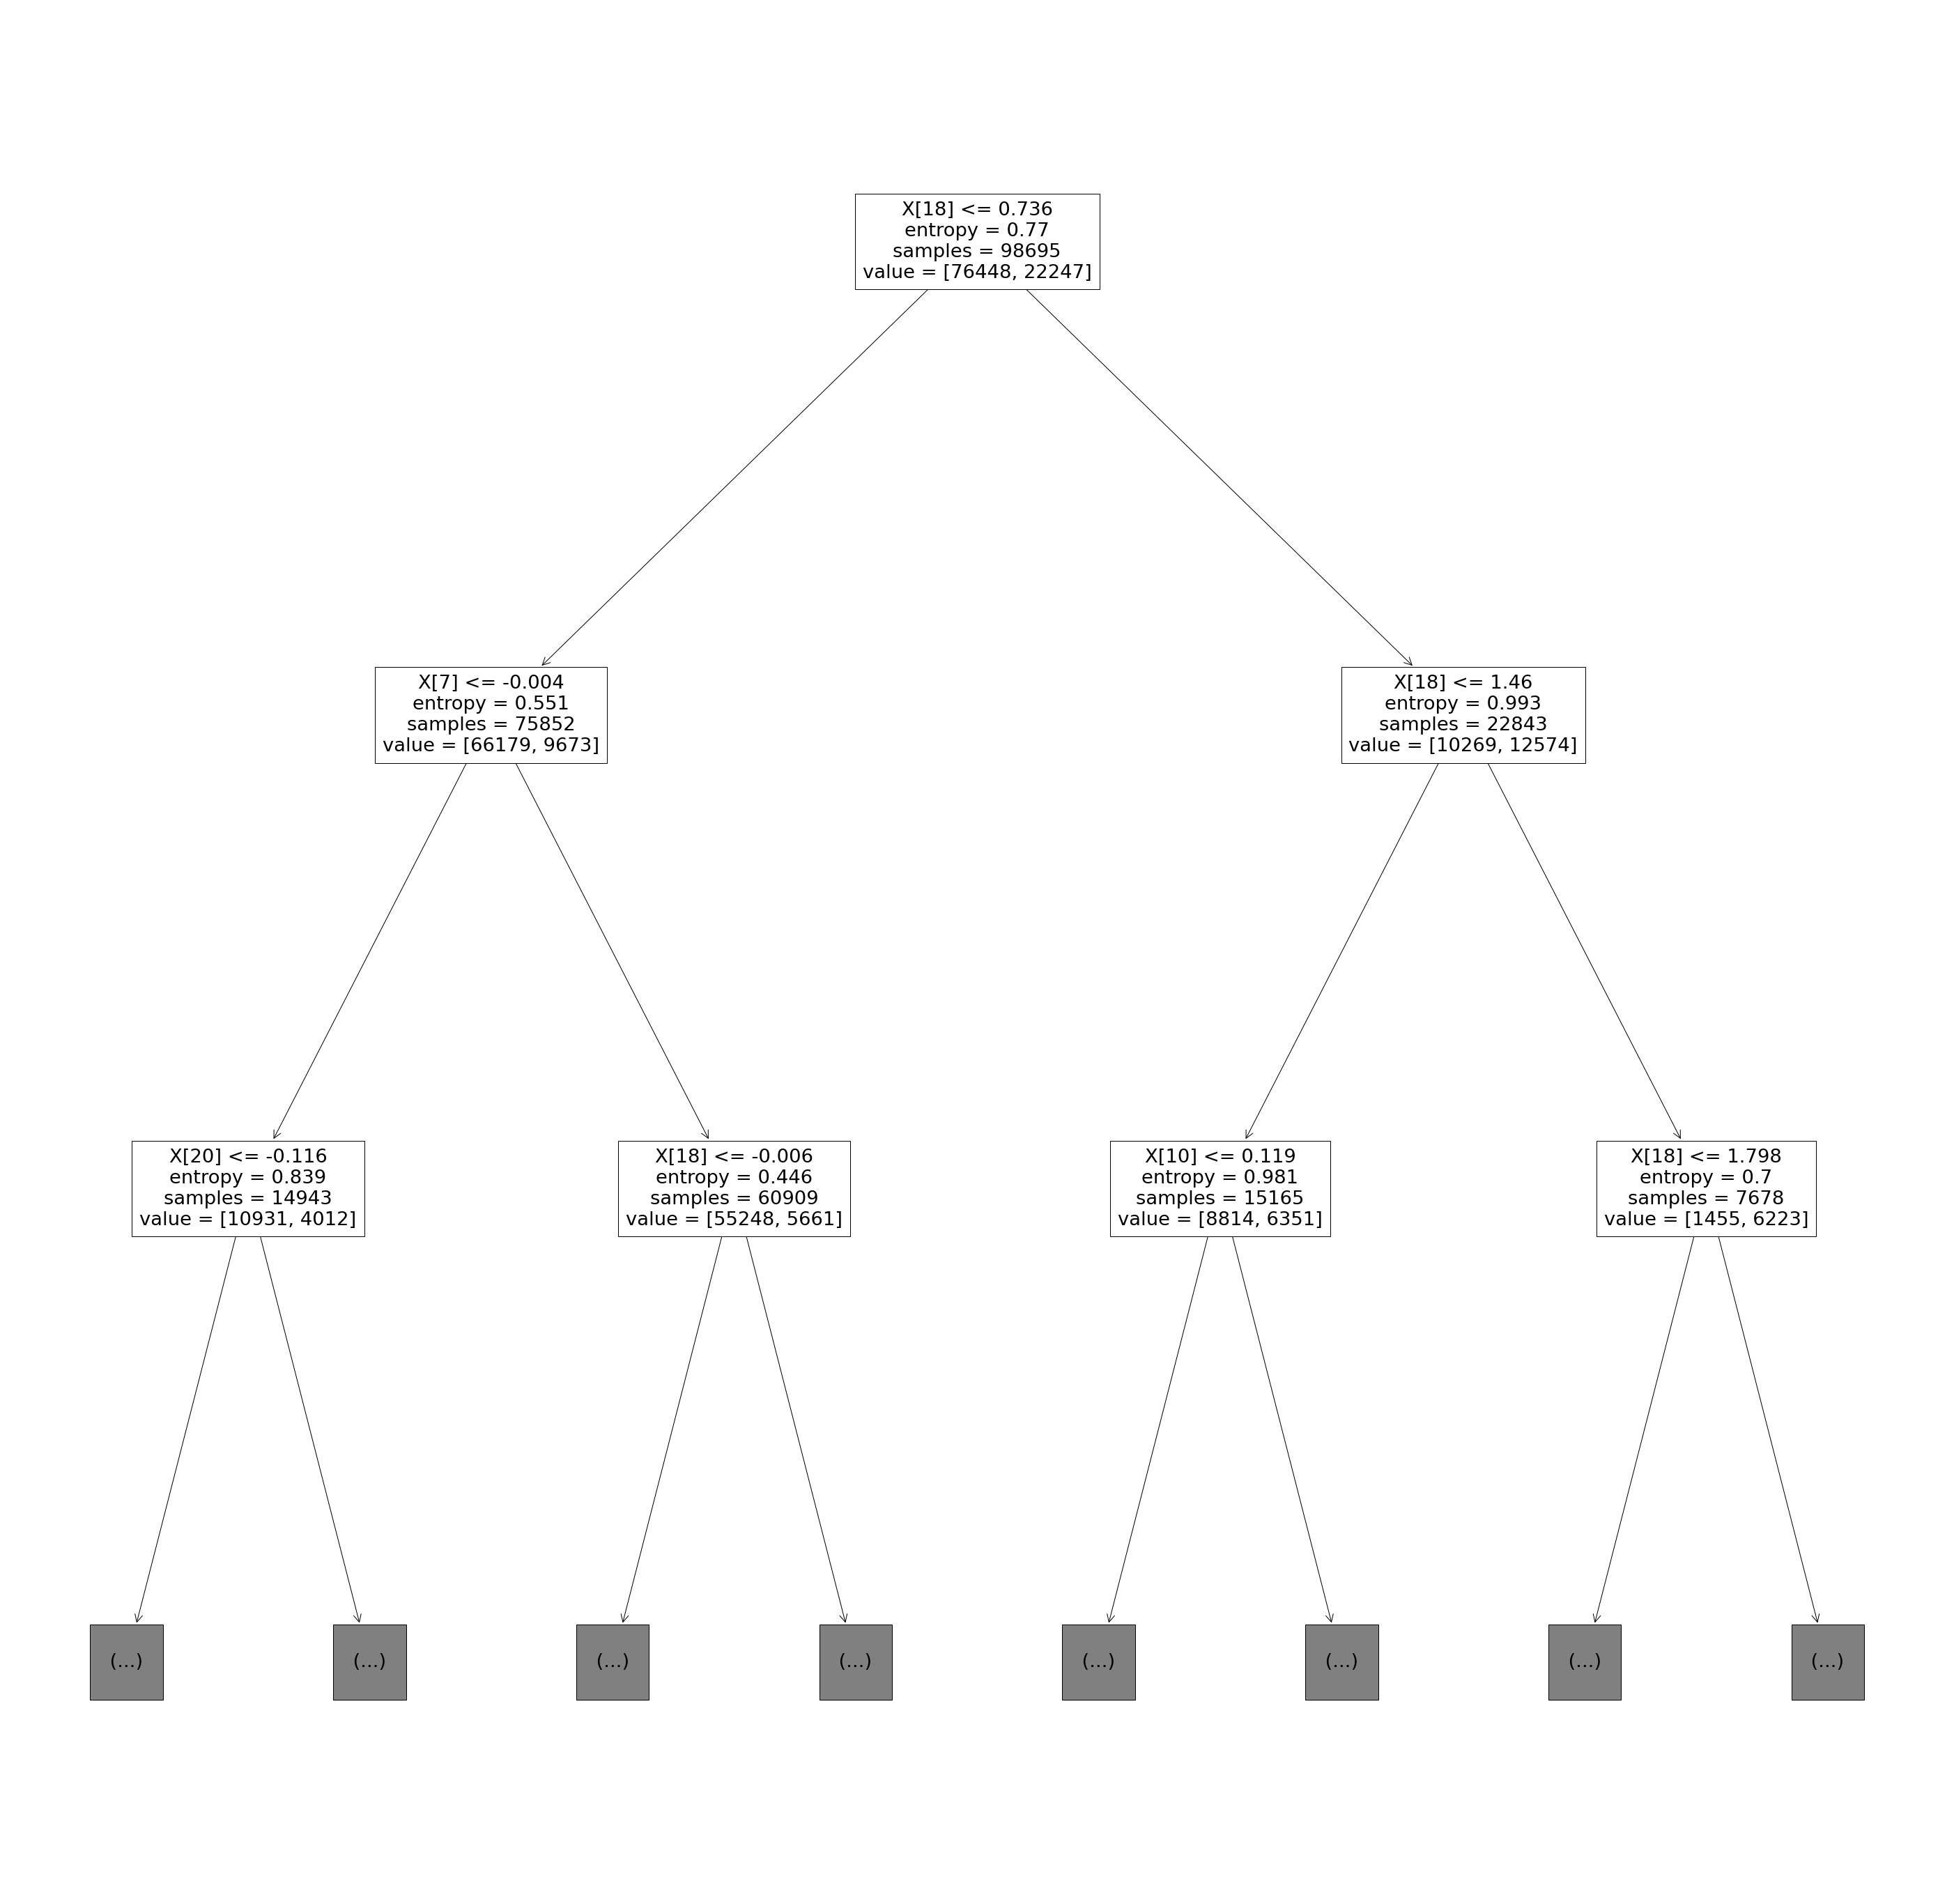

In [8]:
# Print out Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10, max_leaf_nodes= 100, min_samples_split=2)
tree.fit(train_X, train_y)
plt.figure(figsize=(50,50))
plot_tree(tree, max_depth=2)
plt.show()